# Q Reinforcment Learning for Stock Trading

Firstly the dependicenies must be imported.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import random
import pandas as pd

A function for visual of stock data.

In [2]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

Import stock data which can be found on https://finance.yahoo.com.

In [3]:
stock = pd.read_csv('GOLD.csv')
prices = stock.iloc[:,1].values

print("Number data points:", len(prices))

Number data points: 4108


In [4]:
class DecisionPolicy:
    def select_action(self, current_state, step):
        pass
    def update_q(self, state, action, reward, next_state):
        pass

Random decision policy for exploration values. This enables the agent to try random actions for given states to explore the environment and map actions to rewards.

In [5]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
    def select_action(self, current_state):
        action = random.choice(self.actions)
        return action

A function is needed to run the simulations. The following function obtains the current state and calls the select_actions function from DecisionPolicy function. This returns the action "Buy", "Sell" or "Hold". Based on the action the budget and portfolio is updated. The next state is found and the policy is updated using the q function. This is repeated for the length of the data minus the history minus 1. The final portfolio for that simulation is then returned.

In [12]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
            if i % 1000 == 0:
                   print('progress {:.2f}%'.format(float(100*i) / (len(prices) -hist - 1)))
            current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget,num_stocks)))
            current_portfolio = budget + num_stocks * share_value
            action = policy.select_action(current_state, i) #i
            share_value = float(prices[i + hist])
            
            if action == 'Buy' and budget >= share_value:
                budget -= share_value
                num_stocks += 1
            elif action == 'Sell' and num_stocks > 0:
                budget += share_value
                num_stocks -= 1
            else:
                action = 'Hold'
                
            new_portfolio = budget + num_stocks * share_value
            reward = new_portfolio - current_portfolio
            next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget,num_stocks)))
            transitions.append((current_state, action, reward, next_state))
            policy.update_q(current_state, action, reward, next_state)
    portfolio = budget + num_stocks * share_value
    
    print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio

The run_simulations functions runs each simulation and stores the portfolios data to plot. 

In [7]:
def run_simulations(policy, budget, num_stocks, prices, hist):
 
    num_tries = 5
    final_portfolios = list()
    for i in range(num_tries):
        print("Running simulation {}...".format(i+1))
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.plot(final_portfolios)
    plt.show()

Below is an implementation of the Q learning function only choosing random actions. It is clear that the net worth will not increase with just random actions.

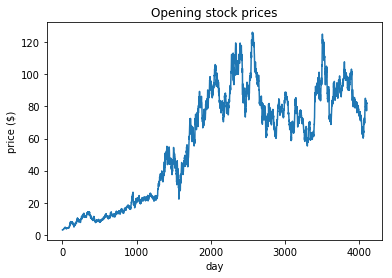

Running simulation 1...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$99500.27009100011	15 shares
Final portfolio: $100735.82013600011
Running simulation 2...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$96875.4173479998	49 shares
Final portfolio: $100911.5474949998
Running simulation 3...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$95691.10496399969	87 shares
Final portfolio: $102857.29522499969
Running simulation 4...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$100337.11748500017	0 shares
Final portfolio: $100337.11748500017
Running simulation 5...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$96432.83755299979	43 shares
Final portfolio: $99974.74768199978


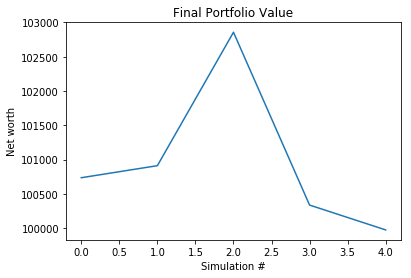

In [13]:
if __name__ == '__main__':
  
    plot_prices(prices)
    actions = ['Buy', 'Sell', 'Hold']
    hist = 3

    policy = RandomDecisionPolicy(actions)
    budget = 100000.0
    num_stocks = 0
    run_simulations(policy, budget, num_stocks, prices, hist)

The QLearingDecisionPolicy class maps the inputs to actions using a neural network. It also updates the q values.
The actions are choosen based on the exploration/explotation principle. The actions are random to begin with but as the steps increase the actions that will yield the highest q value for that state. The action q values are calculated through the neural network. The max action q value is choosen and the action returned.

The update_q function preforms the bellman equation and updates the weights in the nerual network. The current state q value and next state q value is obtained from the nerual network. The current q value is updated using the bellman equation. Q(s,a) = R + gamma(arg_max(Q(s',a').

The weights are then updated using the loss function Adagrad Optimizier. This will allow the agent to obtain a more accurate Q value given the states and therefore chose an action which will maximize long term reward. 

In [9]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20
        
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        #second hidden layer
        #W2 = tf.Variable(tf.random_normal([h1_dim, h1_dim]))
        #b2 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        #h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
        #Third hidden layer
      #  W3 = tf.Variable(tf.random_normal([h1_dim, h1_dim]))
       # b3 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        #h3 = tf.nn.relu(tf.matmul(h2, W3) + b3)
        
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.001).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 900.)
        if random.random() < threshold:
            #Choose best possible action
            action_q_vals = self.sess.run(self.q, feed_dict={self.x:current_state})
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
           
        else:
            # Explore random option
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x:next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma *next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y:action_q_vals})

The actions, policy, history, number of stocks and budget must be assigned values. The stock value prices are plotted and the simulations are run. The results show the agent achieving a larger net worth each simulation by an approximate 65,000 increase. 

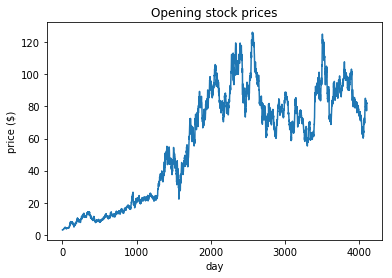

Running simulation 1...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$14.765028999869159	2006 shares
Final portfolio: $165248.99104699984
Running simulation 2...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$19293.619947999996	1816 shares
Final portfolio: $168877.545396
Running simulation 3...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$35350.652607999786	1641 shares
Final portfolio: $170519.82753099978
Running simulation 4...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$54943.48001400013	1394 shares
Final portfolio: $169767.26419600012
Running simulation 5...
progress 0.00%
progress 24.37%
progress 48.73%
progress 73.10%
progress 97.47%
$73765.81986399935	1161 shares
Final portfolio: $169397.39334699936


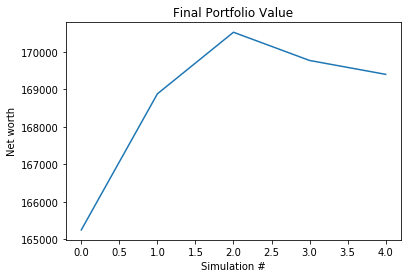

In [11]:
if __name__ == '__main__':
    #prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
  
    plot_prices(prices)
    actions = ['Sell', 'Buy', 'Hold']
    hist = 3

    policy = QLearningDecisionPolicy(actions, hist+2)
    budget = 100000.0
    num_stocks = 0
    run_simulations(policy, budget, num_stocks, prices, hist)